# Loading Datasets

In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
df=pd.DataFrame(columns=['image','label'])

In [3]:
# for a picture containing image of vehicle label is 1.

idx=0
for name in tqdm(glob('data/vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[1]},index=[idx])
    df=df.append(data)    
    idx+=1

100%|██████████████████████████████████████████████████████████████████████████████| 8792/8792 [02:06<00:00, 69.34it/s]


In [4]:
# for a picture doesn't contain image of vehicle label is 0.

for name in tqdm(glob('data/non-vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[0]},index=[idx]) 
    df=df.append(data)
    idx+=1

100%|██████████████████████████████████████████████████████████████████████████████| 8968/8968 [02:32<00:00, 58.66it/s]


#### The above code reads all the images in the directory and creates a DataFrame containing all the vehicle images with their corresponding labels.

# Train test spliting of data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split=StratifiedShuffleSplit(n_splits=1,test_size=0.15,random_state=42)
for train_index,test_index in split.split(df,df['label']):
    train_data=df.iloc[train_index]
    test_data=df.iloc[test_index]
# train_x,test_x,train_y,test_y=train_test_split(df['image'],df['label'],random_state=42,test_size=0.15)

In [6]:
train_img,train_label=train_data['image'],train_data['label']
test_img,test_label=test_data['image'],test_data['label']

# Data Visualization

#### Checking the distribution of labels in the DataFrame using a bar chart and a pie chart:

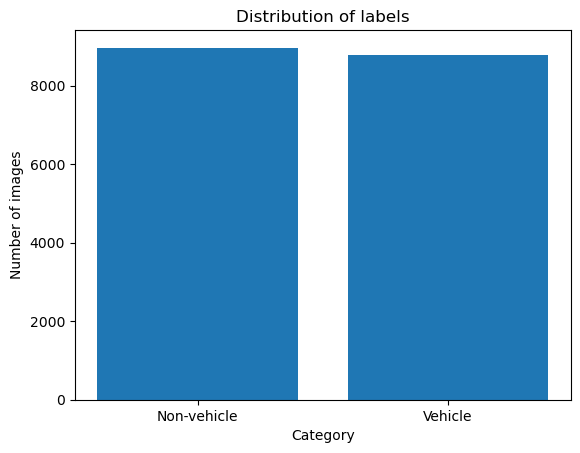

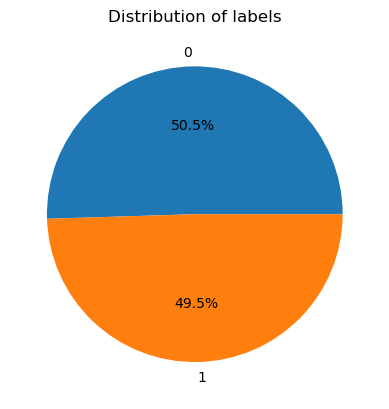

In [7]:
# Count the number of images in each category
label_counts = df['label'].value_counts()

# Plot the distribution as a bar chart
plt.bar(label_counts.index, label_counts.values)
plt.xticks([0, 1], ['Non-vehicle', 'Vehicle'])
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.title('Distribution of labels')
plt.show()

# Plot the distribution as a pie chart
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of labels')
plt.show()

#### Plot sample images for both categories (vehicles and non-vehicles) to get a visual understanding of the data code:

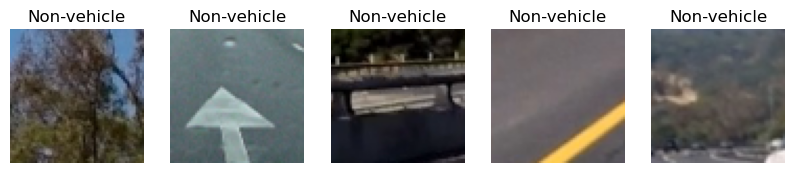

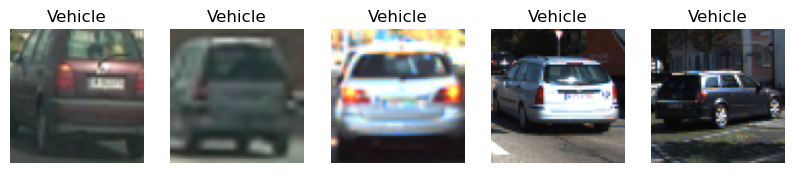

In [8]:
# Select some random images from the non-vehicle category
non_vehicle_images = df[df['label'] == 0]['image'].sample(n=5, random_state=42).values

# Select some random images from the vehicle category
vehicle_images = df[df['label'] == 1]['image'].sample(n=5, random_state=42).values

# Plot the non-vehicle images
plt.figure(figsize=(10, 4))
for i, image in enumerate(non_vehicle_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Non-vehicle')
plt.show()

# Plot the vehicle images
plt.figure(figsize=(10, 4))
for i, image in enumerate(vehicle_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Vehicle')
plt.show()

#### This code is used to visualize a sample of the training data, so we know that the 'test data' split is right for original dataset:

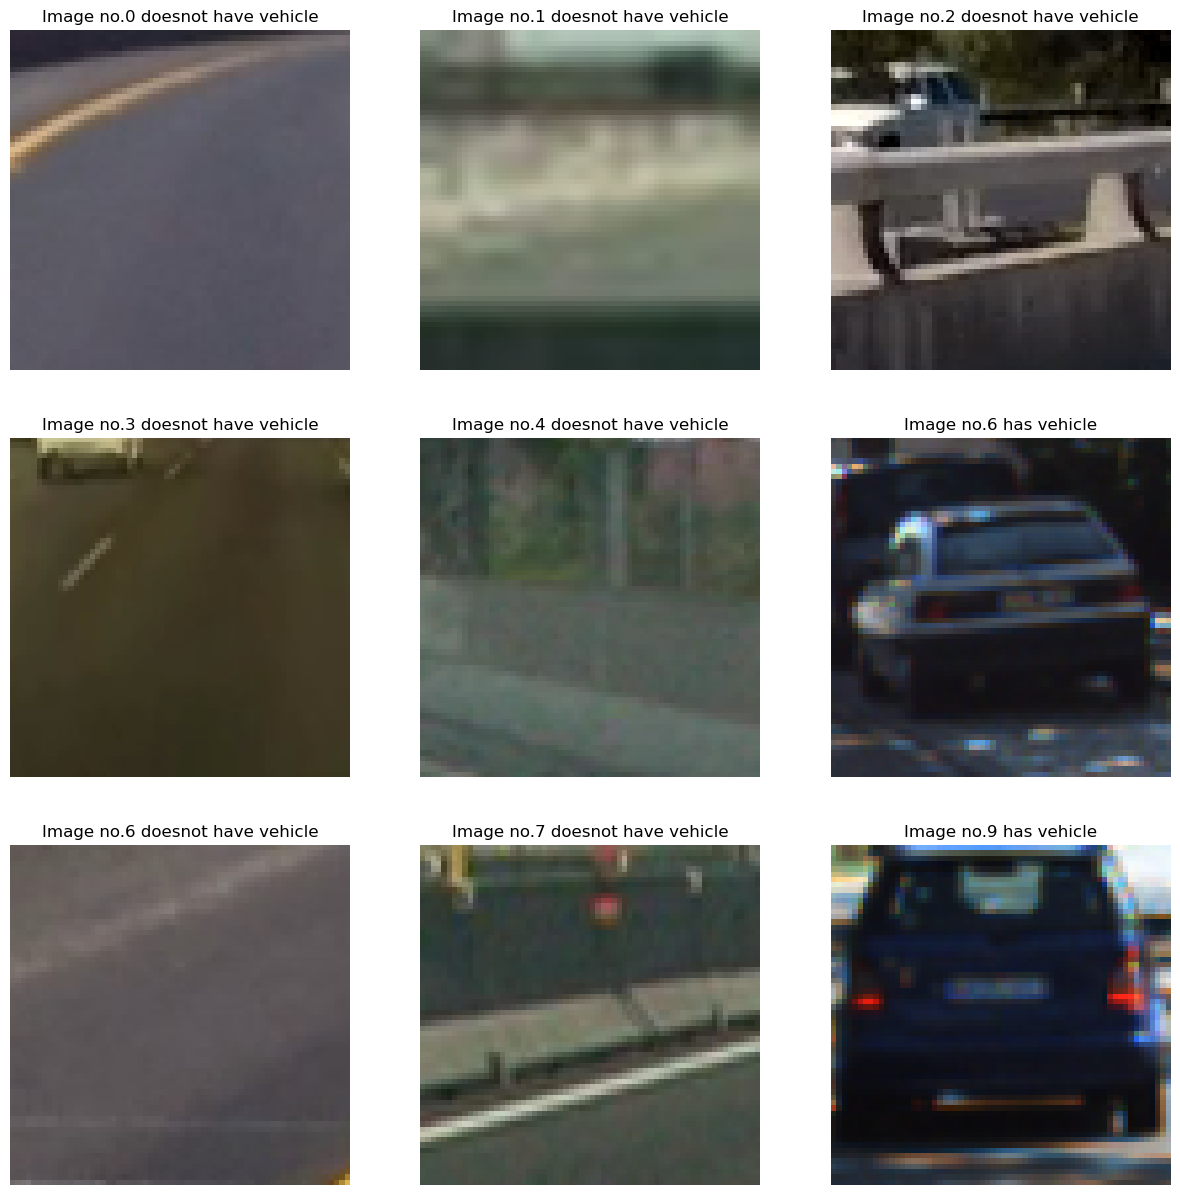

In [9]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    ix=np.random.randint(3000)
    if(train_label.iloc[ix]==1):
        plt.title('Image no.{0} has vehicle'.format(i+1))
    elif(train_label.iloc[ix]==0):
        plt.title('Image no.{0} doesnot have vehicle'.format(i))
    plt.axis('off')
    plt.imshow(train_img.iloc[ix])
plt.show()

# Changing Dimension Of Data

#### The function change_image_dimension is used to reshape the input data from a flattened 1-dimensional list to a 4-dimensional array with dimensions

In [10]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    return data

In [11]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [12]:
train_label=np.array(train_label,dtype=int)
test_label=np.array(test_label,dtype=int)

#### The resulting array can then be used as input to CNN that expects data in this format.

# Callback Functions

#### The learning rate scheduler and early stopping are two common techniques used in deep learning, particularly in Convolutional Neural Networks (CNNs), to improve the model's performance and prevent overfitting:

In [13]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

# Convolutional Neural Network

#### The model has a total of 11 layers (not counting the input layer): 3 Conv2D layers, 3 MaxPool2D layers, 3 BatchNormalization layers, 1 Flatten layer, and 3 Dense layers.

In [14]:
model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(64,64,3)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
r=model.fit(train_img,train_label,validation_data=(test_img,test_label),epochs=10,batch_size=100,callbacks=[early_stop,learning_rate_scheduler])

Epoch 1/10
151/151 [==============================] - 301s 2s/step - loss: 0.0817 - accuracy: 0.9673 - val_loss: 4.7024 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 2/10
151/151 [==============================] - 306s 2s/step - loss: 0.0278 - accuracy: 0.9904 - val_loss: 4.4272 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 3/10
151/151 [==============================] - 383s 3s/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 4.2585 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 4/10
151/151 [==============================] - 362s 2s/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0577 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 5/10
151/151 [==============================] - 290s 2s/step - loss: 0.0070 - accuracy: 0.9974 - val_loss: 0.2587 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 6/10
151/151 [==============================] - 365s 2s/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0100 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 7/10
151/151 [==============================] - 331s 2

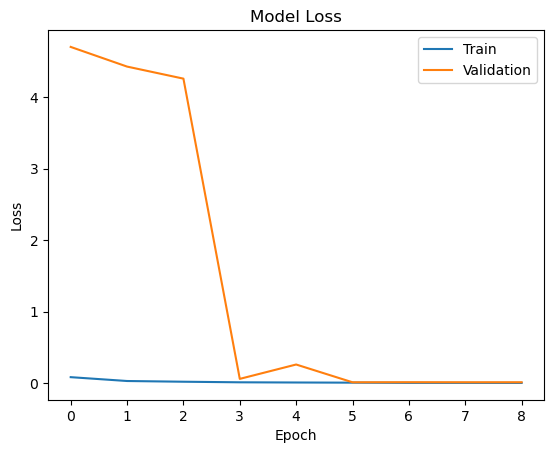

In [17]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

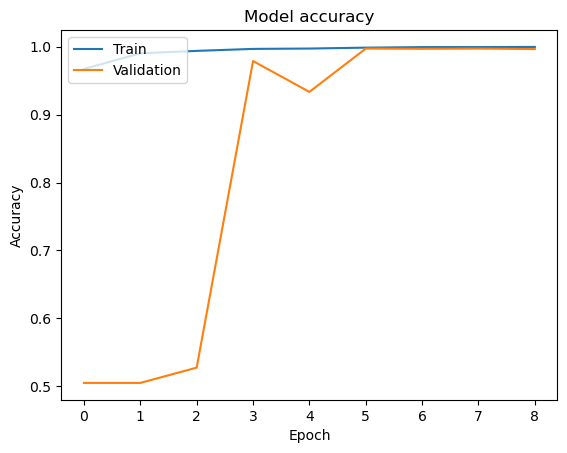

In [18]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualization of Predicted Data

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 91ms/step


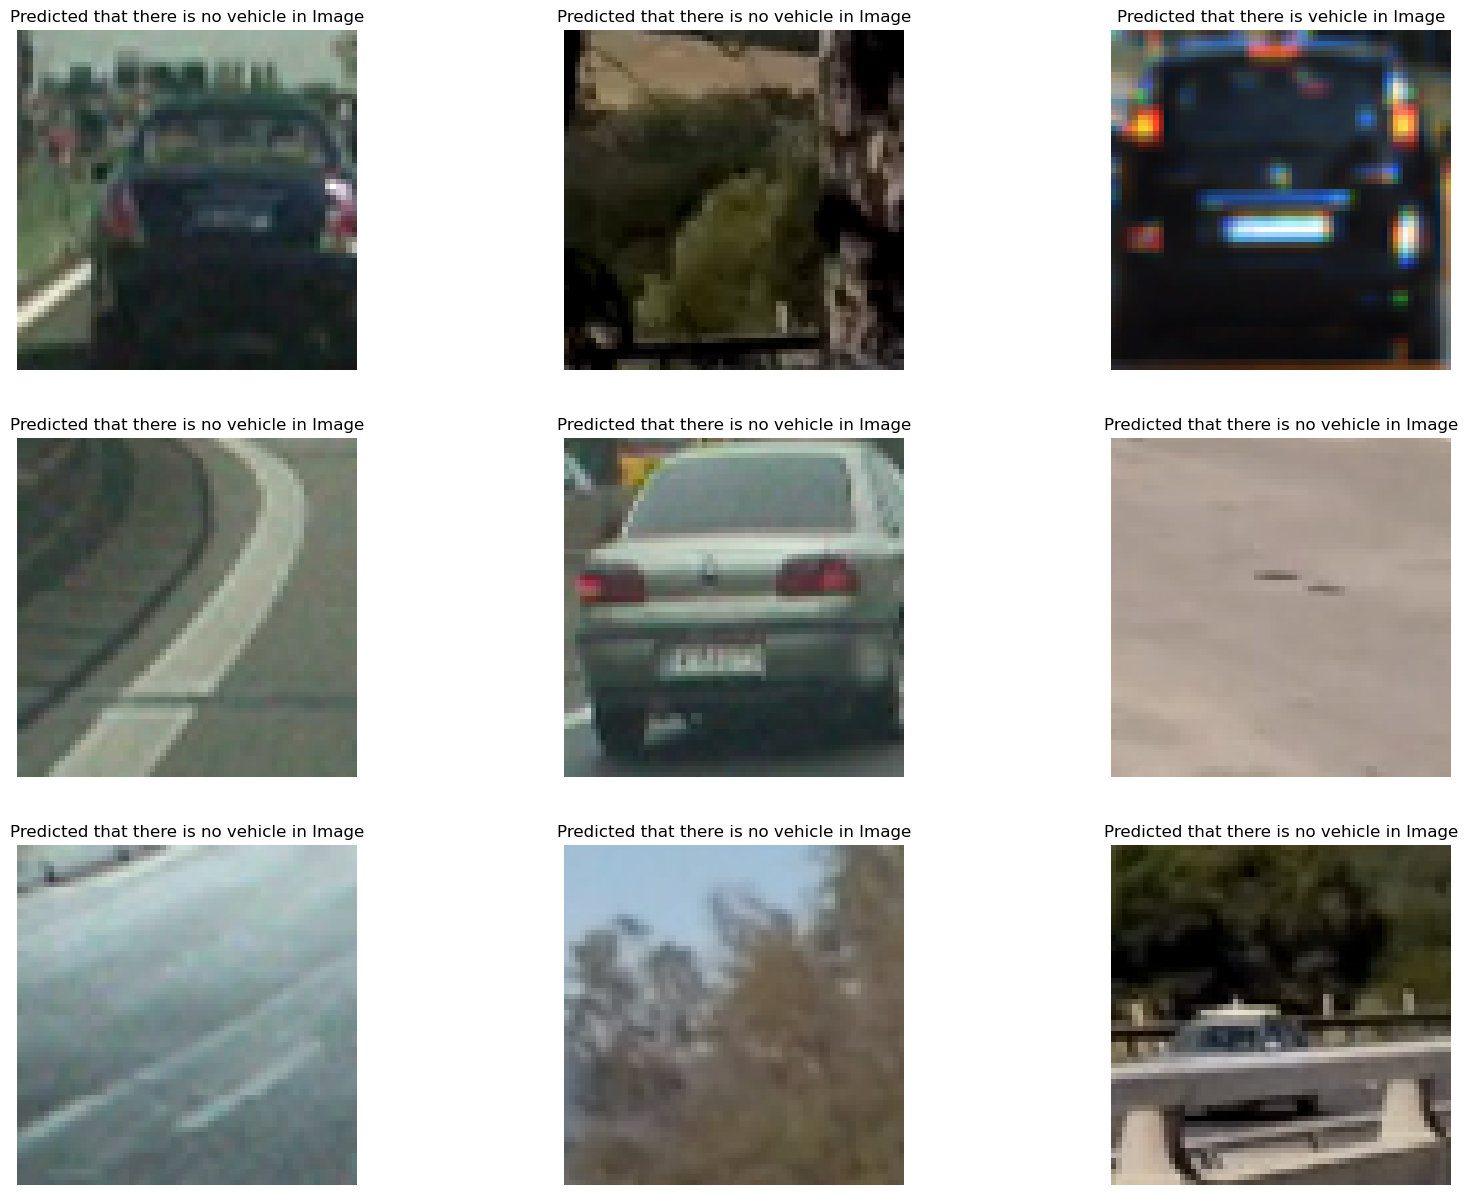

In [19]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    rd_idx=np.random.randint(700)
    predict_x=model.predict(np.reshape(test_img[rd_idx],(-1,64,64,3)))
    classes_x=np.argmax(predict_x,axis=1)
    if predict_x==1:
        plt.title('Predicted that there is vehicle in Image')
    else:
        plt.title('Predicted that there is no vehicle in Image')
    plt.axis('off')
    plt.imshow(test_img[rd_idx])
plt.show()